# Titanic
Work on the [Titanic](https://www.kaggle.com/c/titanic) kaggle competition.

## Useful info
[link](https://towardsdatascience.com/preprocessing-with-sklearn-a-complete-and-comprehensive-guide-670cb98fcfb9) to some good explanation about data preprocessing.

## Overall idea
Build several logistic regression modelto classify people based on their features. I'll start from a very basic one, i.e. logistic regression with just the available features and add more complexity step by step on both feature handling (e.g. feature normalisation, etc.) and the model itself (e.g. more features, more complex models).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import utils
import socket
import operator

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

%matplotlib inline

## Load the data
Load the data and do some very preliminary exploration.

In [2]:
data_path = utils.getDataPath()

In [3]:
df_train = pd.read_csv('{}/train.csv'.format(data_path), skipinitialspace=True)

In [4]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

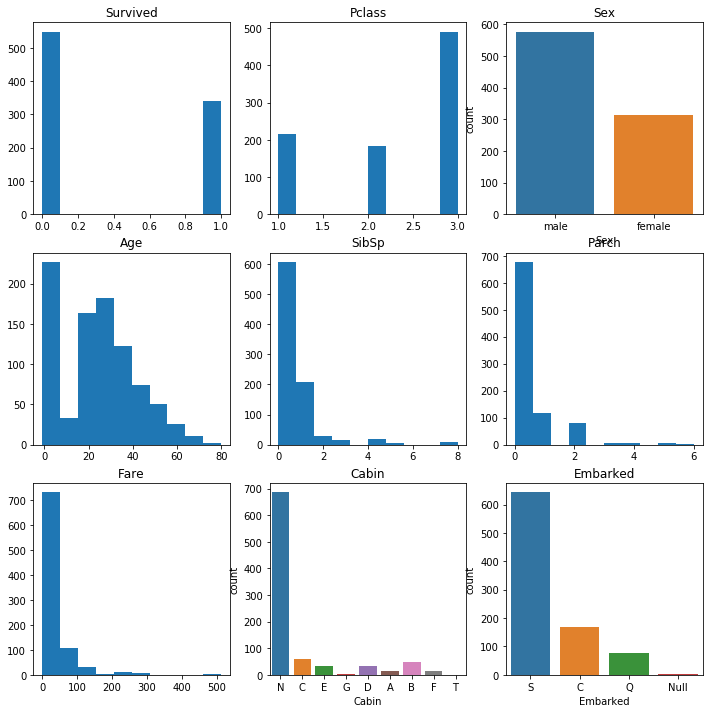

In [6]:
# plot all "plottable" variables
vars = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']

fig, axes = plt.subplots(3, 3, figsize=(12,12))
for i in range(3):
    for j in range(3):
        idx = 3*i + j
        var = vars[idx]
        axes[i,j].set_title(var)
        if is_string_dtype(df_train[var]):
            df_tmp = df_train[var].fillna('Null')
            if var == 'Cabin':
                df_tmp = df_train[var].fillna('Null').str[0]
            sb.countplot(x=df_tmp, ax=axes[i,j])
        else:
            df_tmp = df_train[var].fillna(-1)
            _ = axes[i,j].hist(df_tmp)
        

### Comments on raw vars
`Age` can be `null`, and this happens ha sizeable amount of times (177 times out of 891). At a first look this doesn't seem to be (strongly) correlated to any of the other features.

Third class (`Pclass` = 3) people are not assigned any cabin (`Cabin` = Nan).

### Relations between variables
Try to study the relations between some variables.

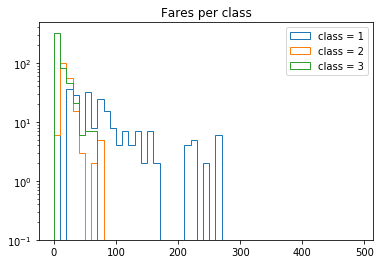

In [7]:
plt.figure()
plt.title('Fares per class')
for c in np.sort(df_train.Pclass.unique()):
    _ = plt.hist(df_train[ df_train.Pclass==c ].Fare, bins=range(0,500,10), histtype='step', label='class = {}'.format(c), log=True)
plt.legend(loc='best')

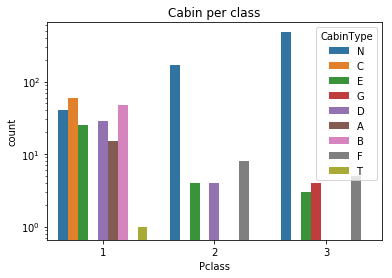

In [8]:
df_tmp = df_train.assign(CabinType = lambda x : x.Cabin.fillna('Null').str[0])

plt.figure()
plt.title('Cabin per class')
sb.countplot(x='Pclass', data=df_tmp, hue='CabinType', log=True)

What is written above is not entirely true: cabins are available for all classes, but they have some kind of distribution. The majority of 3rd class people do not have a cabin, but also some second and first class people do not have a cabin. G cabins seem to be reseved to 3rd class people, while some other types are reserved to second and first class people. The only kind of cabins available for all the three classes are E cabins.

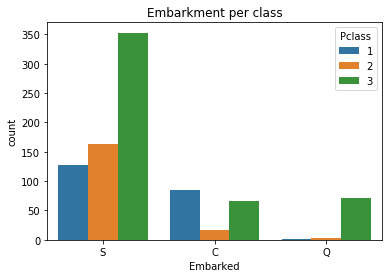

In [9]:
plt.figure()
plt.title('Embarkment per class')
sb.countplot(x='Embarked', data=df_train, hue='Pclass', log=False)

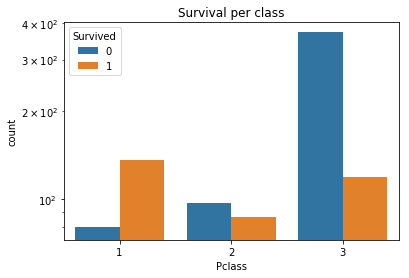

In [10]:
plt.figure()
plt.title('Survival per class')
sb.countplot(x='Pclass', data=df_train, hue='Survived', log=True)

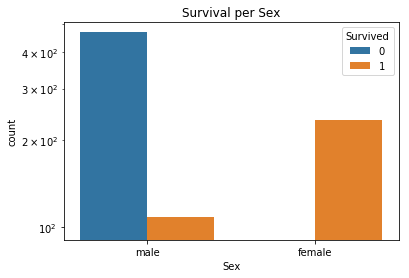

In [11]:
plt.figure()
plt.title('Survival per Sex')
sb.countplot(x='Sex', data=df_train, hue='Survived', log=True)

## Playing with the models
In this section the models are built and fitted.  

### v00: no engineering
In this version I just use the input features as they are. Neverthelsess some data preprocessing is anyway needed:
* replace `NaN`s with a fixed value
* replace `str` value with numeric values (doing the most basic thing)

In [12]:
df00 = df_train.copy()

In [13]:
# interesting features (discarding 'Ticket' for now)
m00_feat_list = ['Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']
m00_input_feat_list = m00_feat_list.copy()

In [14]:
# take care of categorical features
for entry in m00_feat_list:
    if is_string_dtype(df00[entry]): print(entry)

Sex
Cabin
Embarked


In [15]:
# sex: male = 0 / female = 1
df00 = df00.assign(Sex_cat = 0)
df00.loc[ df00['Sex']=='female', 'Sex_cat' ] = 1
m00_input_feat_list = utils.replaceElementInList('Sex', 'Sex_cat', m00_input_feat_list)

In [16]:
# cabin: take the first char, then map to ints
cabin_to_int_dict = {}
idx = 0
for entry in df00.Cabin.fillna('Null').str[0].unique():
    cabin_to_int_dict[entry] = idx
    idx += 1
df00 = df00.assign(Cabin_cat = lambda x : x.Cabin.fillna('Null').str[0].map(cabin_to_int_dict))
#embark_to_int_dict
m00_input_feat_list = utils.replaceElementInList('Cabin', 'Cabin_cat', m00_input_feat_list)

In [17]:
df00.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_cat,Cabin_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0


In [18]:
# embarked: map to ints
embarked_to_int_dict = {}
idx = 0
for entry in df00.Embarked.fillna('Null').unique():
    embarked_to_int_dict[entry] = idx
    idx += 1
df00 = df00.assign(Embarked_cat = lambda x : x.Embarked.map(embarked_to_int_dict))
#embarked_to_int_dict
m00_input_feat_list = utils.replaceElementInList('Embarked', 'Embarked_cat', m00_input_feat_list)

In [19]:
df00.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_cat,Cabin_cat,Embarked_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,1.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1,0.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,0.0


In [20]:
# replace NaNs with -1
for c in df00.columns:
    if not is_string_dtype(df00[c]):
        df00[c] = df00[c].fillna(-1)

In [21]:
# split the features from the target
x00 = df00[m00_input_feat_list].values
y00 = df00['Survived'].values

In [22]:
x00.shape

(891, 8)

In [23]:
# split train and test (let's call it validation not to confuse with the other piece of data)
x00_train, x00_val, y00_train, y00_val = train_test_split(x00, y00, test_size=.15)

Now build the model.

In [24]:
m00 = LogisticRegression()

In [25]:
res00 = m00.fit(x00_train, y00_train)

/Users/francesco/anaconda3/envs/testenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [26]:
y00_train_score = m00.decision_function(x00_train)
y00_val_score = m00.decision_function(x00_val)

In [27]:
#y00_val_pred

In [28]:
p00, e00 = utils.getFullParameters(res00, x00_train)

#### Insights
Here let's see some model insights.

Let's rank the features according to their t-statistic.

In [29]:
# since the utils.getFullParameters(..) function returns values including the intercept, let's add it to the features
m00_final_feat_list = m00_input_feat_list.copy()
m00_final_feat_list.insert(0, 'Intercept')

In [30]:
d00 = {}
for idx in range( len(m00_final_feat_list) ):
    #print(m00_input_feat_list[idx])
    #print(abs((p00 / e00)[idx]))
    d00[ m00_final_feat_list[idx] ] = abs((p00 / e00)[idx])

In [31]:
d00_sorted = sorted(d00.items(), key=operator.itemgetter(1), reverse=True)

In [32]:
d00_sorted

[('Sex_cat', 12.568322388009332),
 ('Pclass', 5.215204167202227),
 ('Age', 3.0180549460993737),
 ('SibSp', 2.730846524646114),
 ('Cabin_cat', 2.022644249704522),
 ('Intercept', 1.6081771368783246),
 ('Parch', 0.7502560337138569),
 ('Fare', 0.6194985603062128),
 ('Embarked_cat', 0.549216064545629)]

### v01: proper mapping
`v01` will be exactly the same as `v00` in terms of which features are used, but as a first step forward the handling of categorical features will be done better, using the tools provided by `sklern`.

In [114]:
df01 = df_train.copy()

In [115]:
# interesting features (discarding 'Ticket' for now)
m01_feat_list = ['Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']
m01_input_feat_list = m01_feat_list.copy()

In [116]:
# check what features have NaNs
for entry in m01_feat_list:
    if df01[df01[ entry ].isna()].shape[0] > 0: print(entry + ' has NaNs')

Age has NaNs
Cabin has NaNs
Embarked has NaNs


In [117]:
df01.Age.fillna( df01.Age.mean(), inplace=True )

In [118]:
# cabin: take the first char
df01 = df01.assign(Cabin_cat = lambda x : x.Cabin.fillna('Null').str[0])
m01_input_feat_list = utils.replaceElementInList('Cabin', 'Cabin_cat', m01_input_feat_list)

In [119]:
df01.Embarked.fillna('Null', inplace=True)

The three categorical features (`Sex`, `Cabin_cat` and `Embarked`) are nominal categories (as opposed to ordinal). So we use a *one-hot* encoding.

In [120]:
df01.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,N
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,N
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,N


In [127]:
onehot = OneHotEncoder(dtype=np.int, sparse=True)

nominals = pd.DataFrame( onehot.fit_transform(df01[ ['Sex', 'Cabin_cat', 'Embarked'] ]).toarray(), columns=pd.get_dummies(df01[ ['Sex', 'Cabin_cat', 'Embarked'] ]).columns.tolist() )

In [128]:
nominals.head()

,Sex_female,Sex_male,Cabin_cat_A,Cabin_cat_B,Cabin_cat_C,Cabin_cat_D,Cabin_cat_E,Cabin_cat_F,Cabin_cat_G,Cabin_cat_N,Cabin_cat_T,Embarked_C,Embarked_Null,Embarked_Q,Embarked_S
0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1


In [129]:
# join the two dataframes
df01 = df01.join(nominals)

In [130]:
# update the input list
# - remove the old categories
for entry in ['Sex', 'Cabin_cat', 'Embarked']:
    m01_input_feat_list.remove(entry)
# - add the new ones
for entry in nominals.columns.tolist():
    if entry in m01_input_feat_list: continue
    m01_input_feat_list.append(entry)    

Now prepare the actual datasets

In [132]:
x01 = df01[m01_input_feat_list].values
y01 = df01['Survived'].values

In [133]:
# split train and test (let's call it validation not to confuse with the other piece of data)
x01_train, x01_val, y01_train, y01_val = train_test_split(x01, y01, test_size=.15)

In [145]:
x01_train.shape

(757, 20)

Now build the model

In [190]:
m01 = LogisticRegression(max_iter=1000000)

In [191]:
res01 = m01.fit(x01_train, y01_train)

/Users/francesco/anaconda3/envs/testenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [192]:
y01_train_score = m01.decision_function(x01_train)
y01_val_score = m01.decision_function(x01_val)

In [193]:
p01, e01 = utils.getFullParameters(res01, x01_train)

/Users/francesco/PersonalProjects/kaggle-titanic/utils.py:46: RuntimeWarning: invalid value encountered in sqrt
  errors = np.sqrt(np.diag(cov))


#### Insigths

In [194]:
# since the utils.getFullParameters(..) function returns values including the intercept, let's add it to the features
m01_final_feat_list = m01_input_feat_list.copy()
m01_final_feat_list.insert(0, 'Intercept')

In [195]:
d01 = {}
for idx in range( len(m01_final_feat_list) ):
    #print(m00_input_feat_list[idx])
    #print(abs((p00 / e00)[idx]))
    d01[ m01_final_feat_list[idx] ] = abs((p01 / e01)[idx])

In [196]:
d01_sorted = sorted(d01.items(), key=operator.itemgetter(1), reverse=True)

In [197]:
d01_sorted

[('Intercept', nan),
 ('Pclass', 4.034821922364199),
 ('Age', 3.9908674918173874),
 ('SibSp', 2.1880469554470063),
 ('Fare', 1.016975425364913),
 ('Parch', 0.3779536791389355),
 ('Cabin_cat_D', 6.864679198021779e-07),
 ('Cabin_cat_E', 5.291286968808081e-07),
 ('Sex_female', 3.695652274619446e-07),
 ('Cabin_cat_F', 3.183308669620948e-07),
 ('Cabin_cat_N', 2.9527347094042596e-07),
 ('Cabin_cat_B', 2.6733193436172497e-07),
 ('Cabin_cat_C', 2.488250131248787e-07),
 ('Cabin_cat_T', 1.7599332613695496e-07),
 ('Cabin_cat_A', 8.781951771865738e-08),
 ('Sex_male', 8.465928077752496e-08),
 ('Cabin_cat_G', 7.89563604861439e-08),
 ('Embarked_C', nan),
 ('Embarked_Null', nan),
 ('Embarked_Q', nan),
 ('Embarked_S', nan)]

## Evaluation and comparison

In [187]:
# model 00
fpr_00v, tpr_00v, thr_00v = roc_curve(y00_val, y00_val_score)
fpr_00t, tpr_00t, thr_00t = roc_curve(y00_train, y00_train_score)
roc_score_00 = roc_auc_score(y00_val, y00_val_score)

In [188]:
# model 01
fpr_01v, tpr_01v, thr_01v = roc_curve(y01_val, y01_val_score)
fpr_01t, tpr_01t, thr_01t = roc_curve(y01_train, y01_train_score)
roc_score_01 = roc_auc_score(y01_val, y01_val_score)

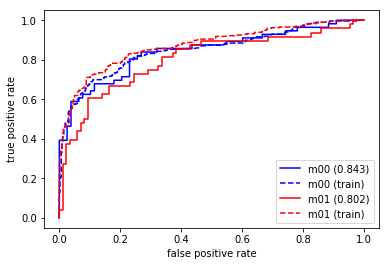

In [189]:
plt.figure()

plt.plot(fpr_00v, tpr_00v, color='b', label='m00 ({:.3})'.format(roc_score_00))
plt.plot(fpr_00t, tpr_00t, color='b', linestyle='--', label='m00 (train)')

plt.plot(fpr_01v, tpr_01v, color='r', label='m01 ({:.3})'.format(roc_score_01))
plt.plot(fpr_01t, tpr_01t, color='r', linestyle='--', label='m01 (train)')

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='best')

## Make the prediction
Here get the final prediction for all the models.